<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->


# Gluon `Dataset`s and `DataLoader`

One of the most critical steps for model training and inference is loading the data: without data you can't do Machine Learning! In this tutorial we use the Gluon API to define a [Dataset](../../../../api/gluon/data/index.rst#datasets) and use a [DataLoader](../../../../api/gluon/data/index.rst#dataloader) to iterate through the dataset in mini-batches.

## Introduction to `Dataset`s

[Dataset](../../../../api/gluon/data/index.rst#datasets) objects are used to represent collections of data, and include methods to load and parse the data (that is often stored on disk). Gluon has a number of different `Dataset` classes for working with image data straight out-of-the-box, but we'll use the [ArrayDataset](../../../../api/gluon/data/index.rst#mxnet.gluon.data.ArrayDataset) to introduce the idea of a `Dataset`.

We first start by generating random data `X` (with 3 variables) and corresponding random labels `y` to simulate a typical supervised learning task. We generate 10 samples and we pass them all to the `ArrayDataset`.

In [1]:
import mxnet as mx
import os
import tarfile

mx.np.random.seed(42) # Fix the seed for reproducibility
X = mx.np.random.uniform(size=(10, 3))
y = mx.np.random.uniform(size=(10, 1))
dataset = mx.gluon.data.dataset.ArrayDataset(X, y)

A key feature of a `Dataset` is the __*ability to retrieve a single sample given an index*__. Our random data and labels were generated in memory, so this `ArrayDataset` doesn't have to load anything from disk, but the interface is the same for all `Dataset`'s.

In [2]:
sample_idx = 4
sample = dataset[sample_idx]

assert len(sample) == 2
assert sample[0].shape == (3, )
assert sample[1].shape == (1, )
print(sample)

(array([0.74707687, 0.37641123, 0.46362457]), array([0.35440788]))


[02:13:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


We get a tuple of a data sample and its corresponding label, which makes sense because we passed the data `X` and the labels `y` in that order when we instantiated the `ArrayDataset`. We don't usually retrieve individual samples from `Dataset` objects though (unless we're quality checking the output samples). Instead we use a `DataLoader`.

## Introduction to `DataLoader`

A [DataLoader](../../../../api/gluon/data/index.rst#dataloader) is used to create mini-batches of samples from a [Dataset](../../../../api/gluon/data/index.rst#datasets), and provides a convenient iterator interface for looping these batches. It's typically much more efficient to pass a mini-batch of data through a neural network than a single sample at a time, because the computation can be performed in parallel. A required parameter of `DataLoader` is the size of the mini-batches you want to create, called `batch_size`.

Another benefit of using `DataLoader` is the ability to easily load data in parallel using [multiprocessing](https://docs.python.org/3.6/library/multiprocessing.html). You can set the `num_workers` parameter to the number of CPUs available on your machine for maximum performance, or limit it to a lower number to spare resources.

In [3]:
from multiprocessing import cpu_count
CPU_COUNT = cpu_count()

data_loader = mx.gluon.data.DataLoader(dataset, batch_size=5, num_workers=CPU_COUNT)

for X_batch, y_batch in data_loader:
    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))

X_batch has shape (5, 3), and y_batch has shape (5, 1)
X_batch has shape (5, 3), and y_batch has shape (5, 1)


`X_batch has shape (5, 3), and y_batch has shape (5, 1)` <!--notebook-skip-line-->

`X_batch has shape (5, 3), and y_batch has shape (5, 1)` <!--notebook-skip-line-->


We can see 2 mini-batches of data (and labels), each with 5 samples, which makes sense given we started with a dataset of 10 samples. When comparing the shape of the batches to the samples returned by the `Dataset`, we've gained an extra dimension at the start which is sometimes called the batch axis.

Our `data_loader` loop will stop when every sample of `dataset` has been returned as part of a batch. Sometimes the dataset length isn't divisible by the mini-batch size, leaving a final batch with a smaller number of samples. `DataLoader`'s default behavior is to return this smaller mini-batch, but this can be changed by setting the `last_batch` parameter to `discard` (which ignores the last batch) or `rollover` (which starts the next epoch with the remaining samples).

## Machine learning with `Dataset`s and `DataLoader`s

You will often use a few different `Dataset` objects in your Machine Learning project. It's essential to separate your training dataset from testing dataset, and it's also good practice to have validation dataset (a.k.a. development dataset) that can be used for optimising hyperparameters.

Using Gluon `Dataset` objects, we define the data to be included in each of these separate datasets. Common use cases for loading data are covered already (e.g. [mxnet.gluon.data.vision.datasets.ImageFolderDataset](../../../../api/gluon/data/vision/datasets/index.rst#mxnet.gluon.data.vision.datasets.ImageFolderDataset)), but it's simple to create your own custom `Dataset` classes for other types of data. You can even use included `Dataset` objects for common datasets if you want to experiment quickly; they download and parse the data for you! In this example we use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset from Zalando Research.

Many of the image `Dataset`'s accept a function (via the optional `transform` parameter) which is applied to each sample returned by the `Dataset`. It's useful for performing data augmentation, but can also be used for more simple data type conversion and pixel value scaling as seen below.

In [4]:
def transform(data, label):
    data = data.astype('float32')/255
    return data, label

train_dataset = mx.gluon.data.vision.datasets.FashionMNIST(train=True).transform(transform)
valid_dataset = mx.gluon.data.vision.datasets.FashionMNIST(train=False).transform(transform)

Data type: float32
Label: 8
Label description: Bag


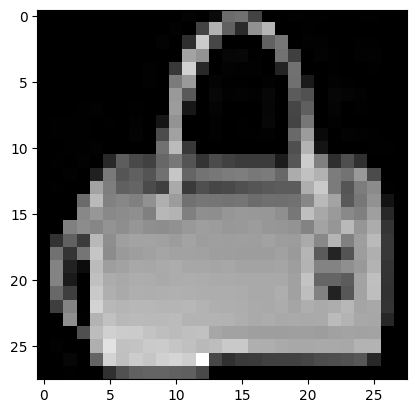

In [5]:
%matplotlib inline
from matplotlib.pylab import imshow

sample_idx = 234
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]
label_desc = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

imshow(data[:,:,0].asnumpy(), cmap='gray')
print("Data type: {}".format(data.dtype))
print("Label: {}".format(label))
print("Label description: {}".format(label_desc[label.item()]))

`Data type: <class 'numpy.float32'>`<!--notebook-skip-line-->

`Label: 8`<!--notebook-skip-line-->

`Label description: Bag`<!--notebook-skip-line-->


![datasets fashion mnist bag](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/gluon/datasets/fashion_mnist_bag.png)<!--notebook-skip-line-->


When training machine learning models it is important to shuffle the training samples every time you pass through the dataset (i.e. each epoch). Sometimes the order of your samples will have a spurious relationship with the target variable, and shuffling the samples helps remove this. With [DataLoader](../../../../api/gluon/data/index.rst#dataloader) it's as simple as adding `shuffle=True`. You don't need to shuffle the validation and testing data though.

If you have more complex shuffling requirements (e.g. when handling sequential data), take a look at [mxnet.gluon.data.BatchSampler](../../../../api/gluon/data/index.rst#mxnet.gluon.data.BatchSampler) and pass this to your `DataLoader` instead.

In [6]:
batch_size = 32
train_data_loader = mx.gluon.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=CPU_COUNT)
valid_data_loader = mx.gluon.data.DataLoader(valid_dataset, batch_size, num_workers=CPU_COUNT)

With both `DataLoader`s defined, we can now train a model to classify each image and evaluate the validation loss at each epoch. Our Fashion MNIST dataset has 10 classes including shirt, dress, sneakers, etc. We define a simple fully connected network with a softmax output and use cross entropy as our loss.

In [7]:
from mxnet import gluon, autograd, ndarray

def construct_net():
    net = gluon.nn.HybridSequential()
    net.add(gluon.nn.Dense(128, activation="relu"))
    net.add(gluon.nn.Dense(64, activation="relu"))
    net.add(gluon.nn.Dense(10))
    return net

# construct and initialize network.
device =  mx.gpu() if mx.device.num_gpus() else mx.cpu()

net = construct_net()
net.hybridize()
net.initialize(mx.init.Xavier(), device=device)
# define loss and trainer.
criterion = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

[02:13:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


In [8]:


epochs = 5
for epoch in range(epochs):
    # training loop (with autograd and trainer steps, etc.)
    cumulative_train_loss = mx.np.zeros(1, device=device)
    training_samples = 0
    for batch_idx, (data, label) in enumerate(train_data_loader):
        data = data.to_device(device).reshape((-1, 784)) # 28*28=784
        label = label.to_device(device)
        with autograd.record():
            output = net(data)
            loss = criterion(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_train_loss += mx.np.sum(loss)
        training_samples += data.shape[0]
    train_loss = cumulative_train_loss.item()/training_samples

    # validation loop
    cumulative_valid_loss = mx.np.zeros(1, device=device)
    valid_samples = 0
    for batch_idx, (data, label) in enumerate(valid_data_loader):
        data = data.to_device(device).reshape((-1, 784)) # 28*28=784
        label = label.to_device(device)
        output = net(data)
        loss = criterion(output, label)
        cumulative_valid_loss += mx.np.sum(loss)
        valid_samples += data.shape[0]
    valid_loss = cumulative_valid_loss.item()/valid_samples

    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}".format(epoch, train_loss, valid_loss))

Epoch 0, training loss: 0.54, validation loss: 0.44


Epoch 1, training loss: 0.40, validation loss: 0.40


Epoch 2, training loss: 0.36, validation loss: 0.34


Epoch 3, training loss: 0.33, validation loss: 0.32


Epoch 4, training loss: 0.31, validation loss: 0.32


`Epoch 0, training loss: 0.54, validation loss: 0.45`<!--notebook-skip-line-->

`...`<!--notebook-skip-line-->

`Epoch 4, training loss: 0.32, validation loss: 0.33`<!--notebook-skip-line-->


# Using own data with included `Dataset`s

Gluon has a number of different [Dataset](../../../../api/gluon/data/index.rst#mxnet.gluon.data.Dataset) classes for working with your own image data straight out-of-the-box. You can get started quickly using the [mxnet.gluon.data.vision.datasets.ImageFolderDataset](../../../../api/gluon/data/vision/datasets/index.rst#mxnet.gluon.data.vision.datasets.ImageFolderDataset) which loads images directly from a user-defined folder, and infers the label (i.e. class) from the folders.

We will run through an example for image classification, but a similar process applies for other vision tasks. If you already have your own collection of images to work with you should partition your data into training and test sets, and place all objects of the same class into seperate folders. Similar to:

```
    ./images/train/car/abc.jpg
    ./images/train/car/efg.jpg
    ./images/train/bus/hij.jpg
    ./images/train/bus/klm.jpg
    ./images/test/car/xyz.jpg
    ./images/test/bus/uvw.jpg
```


You can download the Caltech 101 dataset if you don't already have images to work with for this example, but please note the download is 126MB.

In [9]:

data_folder = "data"
dataset_name = "101_ObjectCategories"
archive_file = "{}.tar.gz".format(dataset_name)
archive_path = os.path.join(data_folder, archive_file)
data_url = "https://s3.us-east-2.amazonaws.com/mxnet-public/"

if not os.path.isfile(archive_path):
    mx.test_utils.download("{}{}".format(data_url, archive_file), dirname = data_folder)
    print('Extracting {} in {}...'.format(archive_file, data_folder))
    tar = tarfile.open(archive_path, "r:gz")
    tar.extractall(data_folder)
    tar.close()
    print('Data extracted.')

After downloading and extracting the data archive, we have two folders: `data/101_ObjectCategories` and `data/101_ObjectCategories_test`. We load the data into separate training and testing  [ImageFolderDataset](../../../../api/gluon/data/vision/datasets/index.rst#mxnet.gluon.data.vision.datasets.ImageFolderDataset)s.

In [10]:
training_path = os.path.join(data_folder, dataset_name)
testing_path = os.path.join(data_folder, "{}_test".format(dataset_name))

We instantiate the [ImageFolderDataset](../../../../api/gluon/data/vision/datasets/index.rst#mxnet.gluon.data.vision.datasets.ImageFolderDataset)s by providing the path to the data, and the folder structure will be traversed to determine which image classes are available and which images correspond to each class. You must take care to ensure the same classes are both the training and testing datasets, otherwise the label encodings can get muddled.

Optionally, you can pass a `transform` parameter to these `Dataset`'s as we've seen before.

In [11]:
train_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(training_path)
test_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(testing_path)

Samples from these datasets are tuples of data and label. Images are loaded from disk, decoded and optionally transformed when the `__getitem__(i)` method is called (equivalent to `train_dataset[i]`).

As with the Fashion MNIST dataset the labels will be integer encoded. You can use the `synsets` property of the [ImageFolderDataset](../../../../api/gluon/data/vision/datasets/index.rst#mxnet.gluon.data.vision.datasets.ImageFolderDataset)s to retrieve the original descriptions (e.g. `train_dataset.synsets[i]`).

Data type: uint8
Label: 1
Label description: Faces_easy


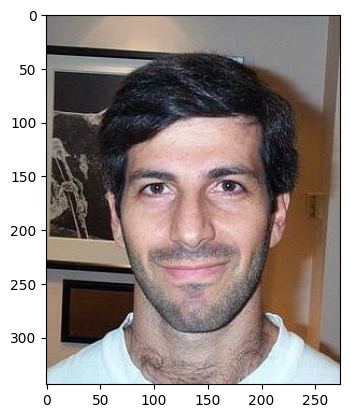

In [12]:
sample_idx = 539
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

imshow(data.asnumpy(), cmap='gray')
print("Data type: {}".format(data.dtype))
print("Label: {}".format(label))
print("Label description: {}".format(train_dataset.synsets[label]))
assert label == 1

`Data type: <class 'numpy.uint8'>`<!--notebook-skip-line-->

`Label: 1`<!--notebook-skip-line-->

`Label description: Faces_easy` <!--notebook-skip-line-->


![datasets caltech101 face](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/gluon/datasets/caltech101_face.png)<!--notebook-skip-line-->


# Using own data with custom `Dataset`s

Sometimes you have data that doesn't quite fit the format expected by the included [Dataset](../../../../api/gluon/data/index.rst#mxnet.gluon.data.Dataset)s. You might be able to preprocess your data to fit the expected format, but it is easy to create your own dataset to do this.

All you need to do is create a class that implements a `__getitem__` method, that returns a sample (i.e. a tuple of [mx.np.ndarray](../../../../api/np/arrays.ndarray.rst#the-n-dimensional-array-ndarray)'s).

# Appendix: Upgrading from Module `DataIter` to Gluon `DataLoader`

Before Gluon's [DataLoader](../../../../api/gluon/data/index.rst#Dataloader), MXNet used [DataIter](../../../../api/legacy/io/index.rst#mxnet.io.DataIter) objects for loading data for training and testing. `DataIter` has a similar interface for iterating through data, but it isn't directly compatible with typical Gluon `DataLoader` loops. Unlike Gluon `DataLoader` which often returns a tuple of `(data, label)`, a `DataIter` returns a [DataBatch](../../../../api/legacy/io/index.rst#mxnet.io.DataBatch) object that has `data` and `label` properties. Switching to `DataLoader`'s is highly recommended when using Gluon, but you'll need to take care of pre-processing steps such as augmentations in a `transform` function.

So you can get up and running with Gluon quicker if you have already implemented complex pre-processing steps using `DataIter`, we have provided a simple class to wrap existing `DataIter` objects so they can be used in a typical Gluon training loop. You can use this class for `DataIter`s such as [mxnet.image.ImageIter](../../../../api/legacy/image/index.rst#mxnet.image.ImageIter) and [mxnet.io.ImageRecordIter](../../../../api/legacy/io/index.rst#mxnet.io.ImageDetRecordIter) that have single data and label arrays.

In [13]:
class DataIterLoader():
    def __init__(self, data_iter):
        self.data_iter = data_iter

    def __iter__(self):
        self.data_iter.reset()
        return self

    def __next__(self):
        batch = self.data_iter.__next__()
        assert len(batch.data) == len(batch.label) == 1
        data = batch.data[0]
        label = batch.label[0]
        return data, label

    def next(self):
        return self.__next__() # for Python 2

In [14]:
data_iter = mx.io.NDArrayIter(data=X, label=y, batch_size=5)
data_iter_loader = DataIterLoader(data_iter)
for X_batch, y_batch in data_iter_loader:
    assert X_batch.shape == (5, 3)
    assert y_batch.shape == (5, 1)

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->